In [1]:
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

In [2]:
# --- FIX IS HERE ---
# Use '../src' because your notebook is inside the 'notebooks' folder
# and the 'src' folder is one level up.
sys.path.append(os.path.abspath('../src'))

# 2. Reload extension
%load_ext autoreload
%autoreload 2

# 3. Import Modules
try:
    # Remember: Import the FILENAME, not the function name
    import data_fetcher       # File is src/data_fetcher.py
    import data_processor    # File is src/processed_data.py
    import feature_generator  # File is src/feature_generator.py
    import labeler            # File is src/labeler.py
    
    print("✅ Modules imported successfully!")
    print(f"Python found them at: {os.path.abspath('../src')}")
    
except ImportError as e:
    print(f"Import Error: {e}")
    print("Check if the file exists in the folder printed above.")

✅ Modules imported successfully!
Python found them at: c:\Users\atien\Downloads\Data Science Class\Capstone_Project\Crypto_Classifier\src


In [3]:
import os
import sys
import importlib

# ==========================================
# DEFINING THE NEW SMART LABELER CODE
# ==========================================
labeler_code = """
import pandas as pd
import numpy as np
import os

def create_labels(method='dynamic', threshold=0.02, sensitivity=0.5):
    '''
    Generates labels for Buy/Sell/Hold.
    
    Args:
        method (str): 'fixed' (use hard % number) or 'dynamic' (use volatility).
        threshold (float): Used for 'fixed' method (e.g., 0.02 for 2%).
        sensitivity (float): Used for 'dynamic' method. Multiplier of volatility.
                             0.5 means if price moves > 0.5 * StdDev, it's a signal.
                             Lower = More signals (Fixes Imbalance).
                             Higher = Fewer signals (More precise).
    '''
    # --- PATH SETUP ---
    current_script_dir = os.path.dirname(os.path.abspath(__file__))
    project_root = os.path.dirname(current_script_dir)
    input_path = os.path.join(project_root, 'data', 'feature_engineered', 'feature_engineered_data.csv')
    output_dir = os.path.join(project_root, 'data', 'labeled')
    output_path = os.path.join(output_dir, 'labeled_data.csv')

    print(f" Starting Smart Labeling ({method} mode)...")
    
    if not os.path.exists(input_path):
        print(f" Error: File not found at {input_path}")
        return None

    df = pd.read_csv(input_path)
    
    # 1. Calculate Future Return (The Target)
    df['future_return'] = df['close'].pct_change().shift(-1)
    
    # 2. Define Thresholds
    if method == 'dynamic':
        # Check if volatility exists, if not re-calculate
        if 'volatility' not in df.columns:
            df['volatility'] = df['close'].pct_change().rolling(window=20).std()
        
        # Dynamic: Threshold changes every day based on market noise
        # We fill NaNs with the mean so we don't lose data
        volatility = df['volatility'].fillna(df['volatility'].mean())
        
        df['threshold_buy'] = volatility * sensitivity
        df['threshold_sell'] = -volatility * sensitivity
    else:
        # Fixed: Hardcoded number
        df['threshold_buy'] = threshold
        df['threshold_sell'] = -threshold

    # 3. Apply Labels
    # 2 = BUY, 0 = SELL, 1 = HOLD
    conditions = [
        (df['future_return'] > df['threshold_buy']),
        (df['future_return'] < df['threshold_sell'])
    ]
    
    df['label'] = np.select(conditions, [2, 0], default=1)

    # 4. Cleanup & Save
    df = df.dropna(subset=['future_return'])
    
    os.makedirs(output_dir, exist_ok=True)
    df.to_csv(output_path, index=False)

    print(f" Labels Generated. Saved to: {output_path}")
    print("--- Class Distribution ---")
    print(df['label'].value_counts().sort_index())
    
    return df
"""

# ==========================================
# WRITE TO FILE
# ==========================================
# Determine path
if os.path.exists("../src"):
    file_path = "../src/labeler.py"
else:
    file_path = "src/labeler.py"

with open(file_path, "w", encoding="utf-8") as f:
    f.write(labeler_code)
print(f" Successfully updated {file_path}")

 Successfully updated ../src/labeler.py


In [10]:
# Import all your modules
import sys
import os
import importlib

# Point to src folder
sys.path.append(os.path.abspath('../src'))

import data_fetcher
import data_processor
import feature_generator
import labeler

# Force reload to ensure latest changes are used
importlib.reload(data_fetcher)
importlib.reload(data_processor)
importlib.reload(feature_generator)
importlib.reload(labeler)

print("STARTING PIPELINE...\n")

# 1. Fetch
print("--- 1. Fetching Data ---")
data_fetcher.fetch_binance_data()

# 2. Clean
print("\n--- 2. Cleaning Data ---")
data_processor.clean_raw_data()

# 3. Features
print("\n--- 3. Generating Features ---")
feature_generator.feature_generator()


# 4. Labels
print("\n--- 4. Generating Labels ---")
df_final = labeler.create_labels(method='dynamic', sensitivity=0.5)

# Convert open_time back to datetime object immediately after loading
print("   Fixing datetime format...")
df_final['open_time'] = pd.to_datetime(df_final['open_time'])

# 5. Success
print(f"\n Pipeline Complete! Final Dataset Shape: {df_final.shape}")
print(f"   Date Column Type: {df_final['open_time'].dtype}") # Should say datetime64[ns]
df_final.head()

STARTING PIPELINE...

--- 1. Fetching Data ---
Fetching 1000 rows of 1d data for BTCUSDT...
✅ Data saved to c:\Users\atien\Downloads\Data Science Class\Capstone_Project\Crypto_Classifier\data\raw\raw_data.csv

--- 2. Cleaning Data ---
Reading raw data from: c:\Users\atien\Downloads\Data Science Class\Capstone_Project\Crypto_Classifier\data\raw\raw_data.csv
Cleaning data types...
✅ Successfully cleaned data.
   Rows: 1000
   Saved to: c:\Users\atien\Downloads\Data Science Class\Capstone_Project\Crypto_Classifier\data\processed\processed_data.csv

--- 3. Generating Features ---
🚀 Starting feature engineering...
   Reading from: c:\Users\atien\Downloads\Data Science Class\Capstone_Project\Crypto_Classifier\data\processed\processed_data.csv
   Calculating technical indicators...
✅ Features generated.
   Dropped 199 rows (warmup for indicators).
   Saved to: c:\Users\atien\Downloads\Data Science Class\Capstone_Project\Crypto_Classifier\data\feature_engineered\feature_engineered_data.csv

--

,open_time,open,high,low,close,volume,rsi,macd,macd_signal,macd_hist,...,sma_200,bb_high,bb_low,volatility,pct_change_1d,pct_change_7d,future_return,threshold_buy,threshold_sell,label
0,2023-09-22,26568.08,26743.38,26468.77,26580.14,18198.22920,50.002521,0.035627,-141.892455,141.928081,...,27813.84560,27246.157741,25247.694259,0.012822,0.000454,-0.000747,-0.000157,0.006411,-0.006411,1
1,2023-09-23,26580.14,26632.81,26509.00,26575.96,9440.70260,49.942903,0.836081,-113.346748,114.182828,...,27835.73560,27277.791132,25276.535868,0.012813,-0.000157,0.000613,-0.012326,0.006406,-0.006406,0
2,2023-09-24,26575.97,26738.54,26122.08,26248.38,15706.65771,45.376799,-24.678049,-95.613008,70.934959,...,27858.45030,27277.531920,25319.031080,0.013087,-0.012326,-0.010522,0.002150,0.006544,-0.006544,1
3,2023-09-25,26248.39,26446.15,25990.46,26304.81,26266.20390,46.287807,-39.884981,-84.467403,44.582421,...,27888.16325,27275.267225,25372.566775,0.013079,0.002150,-0.017102,-0.003161,0.006540,-0.006540,1
4,2023-09-26,26304.80,26397.46,26088.34,26221.67,18495.35066,45.094497,-57.976966,-79.169315,21.192349,...,27918.51815,27264.289505,25429.716495,0.013104,-0.003161,-0.036332,0.005771,0.006552,-0.006552,1


In [11]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 800 entries, 0 to 799
Data columns (total 22 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   open_time       800 non-null    datetime64[ns]
 1   open            800 non-null    float64       
 2   high            800 non-null    float64       
 3   low             800 non-null    float64       
 4   close           800 non-null    float64       
 5   volume          800 non-null    float64       
 6   rsi             800 non-null    float64       
 7   macd            800 non-null    float64       
 8   macd_signal     800 non-null    float64       
 9   macd_hist       800 non-null    float64       
 10  sma_20          800 non-null    float64       
 11  sma_50          800 non-null    float64       
 12  sma_200         800 non-null    float64       
 13  bb_high         800 non-null    float64       
 14  bb_low          800 non-null    float64       
 15  volatility 

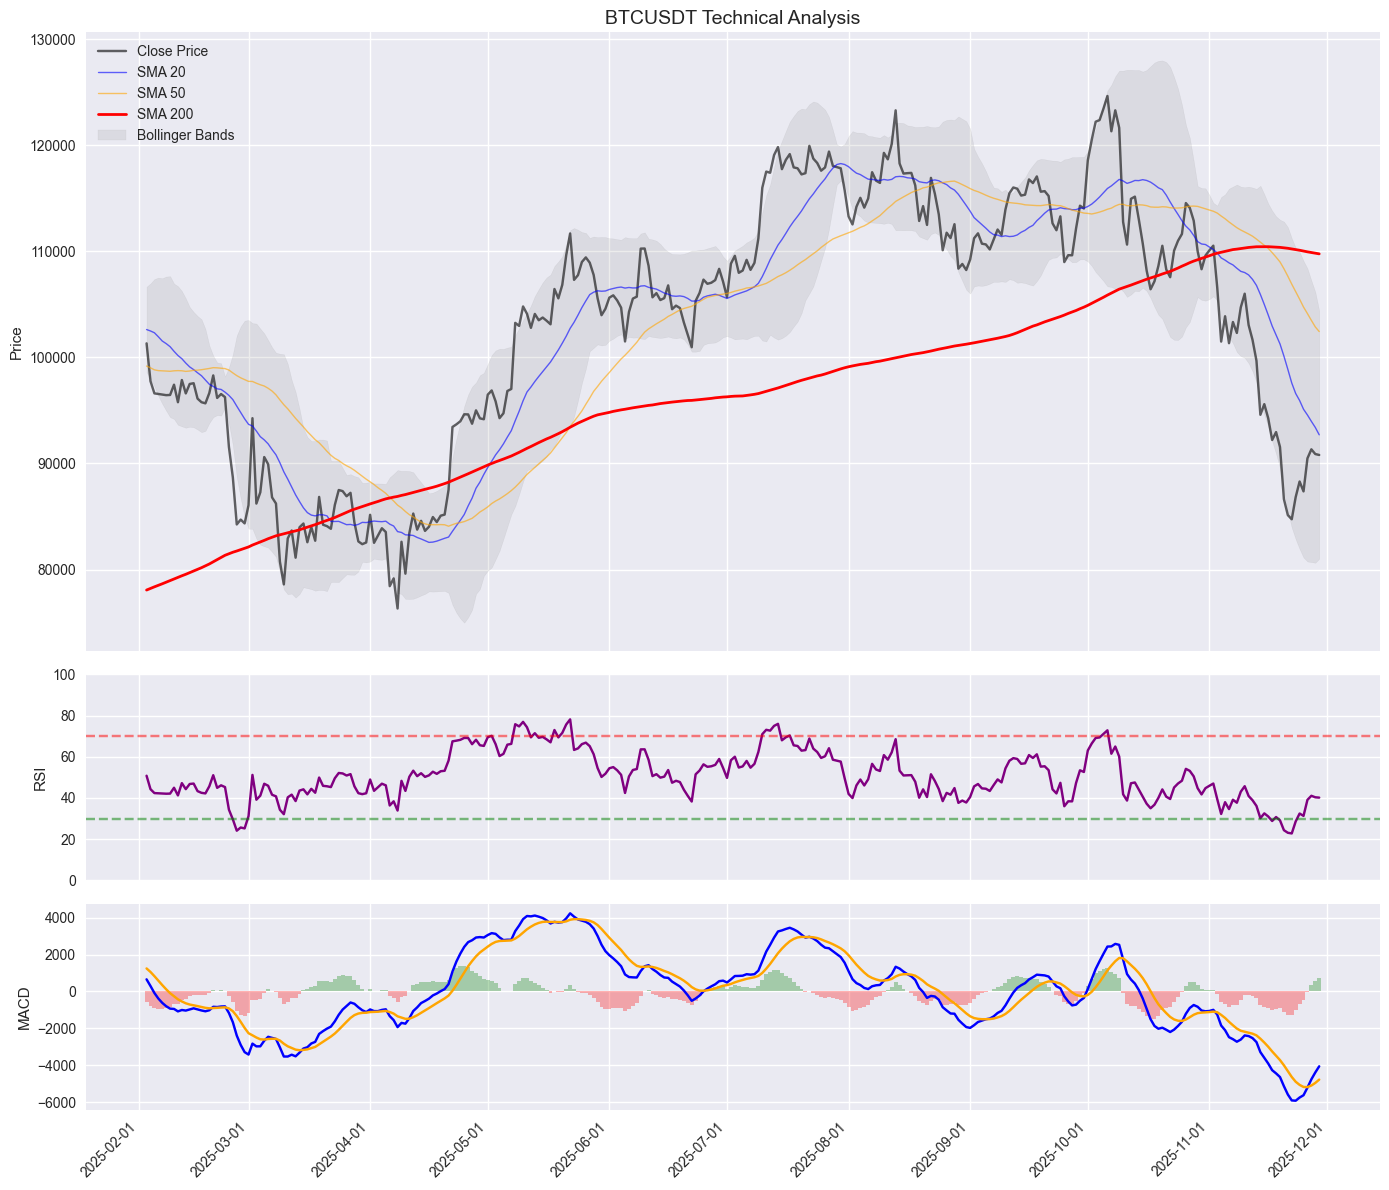

In [12]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import seaborn as sns

# Set style
plt.style.use('seaborn-v0_8')

# 1. PREPARE DATA
# Copy the last 300 days
subset = df_final.tail(300).copy()

# CRITICAL FIX: Force conversion to datetime again just to be 100% sure
subset['open_time'] = pd.to_datetime(subset['open_time'])

# 2. PLOT SETUP
# sharex=True hides the X-axis labels for the top charts to look cleaner. 
# The labels will only appear on the BOTTOM chart.
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(14, 12), sharex=True, gridspec_kw={'height_ratios': [3, 1, 1]})

# --- CHART 1: PRICE ---
ax1.plot(subset['open_time'], subset['close'], label='Close Price', color='black', alpha=0.6)
ax1.plot(subset['open_time'], subset['sma_20'], label='SMA 20', color='blue', alpha=0.6, linewidth=1)
ax1.plot(subset['open_time'], subset['sma_50'], label='SMA 50', color='orange', alpha=0.6, linewidth=1)

if 'sma_200' in subset.columns:
    ax1.plot(subset['open_time'], subset['sma_200'], label='SMA 200', color='red', linewidth=2)

ax1.fill_between(subset['open_time'], subset['bb_high'], subset['bb_low'], color='gray', alpha=0.15, label='Bollinger Bands')
ax1.set_title('BTCUSDT Technical Analysis', fontsize=14)
ax1.set_ylabel('Price')
ax1.legend(loc='upper left')
ax1.grid(True)

# --- CHART 2: RSI ---
ax2.plot(subset['open_time'], subset['rsi'], color='purple', label='RSI')
ax2.axhline(70, color='red', linestyle='--', alpha=0.5)
ax2.axhline(30, color='green', linestyle='--', alpha=0.5)
ax2.set_ylabel('RSI')
ax2.set_ylim(0, 100)
ax2.grid(True)

# --- CHART 3: MACD ---
ax3.plot(subset['open_time'], subset['macd'], label='MACD', color='blue')
ax3.plot(subset['open_time'], subset['macd_signal'], label='Signal', color='orange')
hist_colors = ['green' if x >= 0 else 'red' for x in subset['macd_hist']]
ax3.bar(subset['open_time'], subset['macd_hist'], color=hist_colors, alpha=0.3, width=1.0)
ax3.set_ylabel('MACD')
ax3.grid(True)

# --- CRITICAL FIX: FORMATTING THE DATE AXIS ---
# We apply this to ax3 because it is the bottom chart
ax3.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d')) # Format: 2023-01-01
ax3.xaxis.set_major_locator(mdates.AutoDateLocator()) # Let matplotlib pick best spacing

# Rotate dates to prevent overlapping
plt.setp(ax3.xaxis.get_majorticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.show()

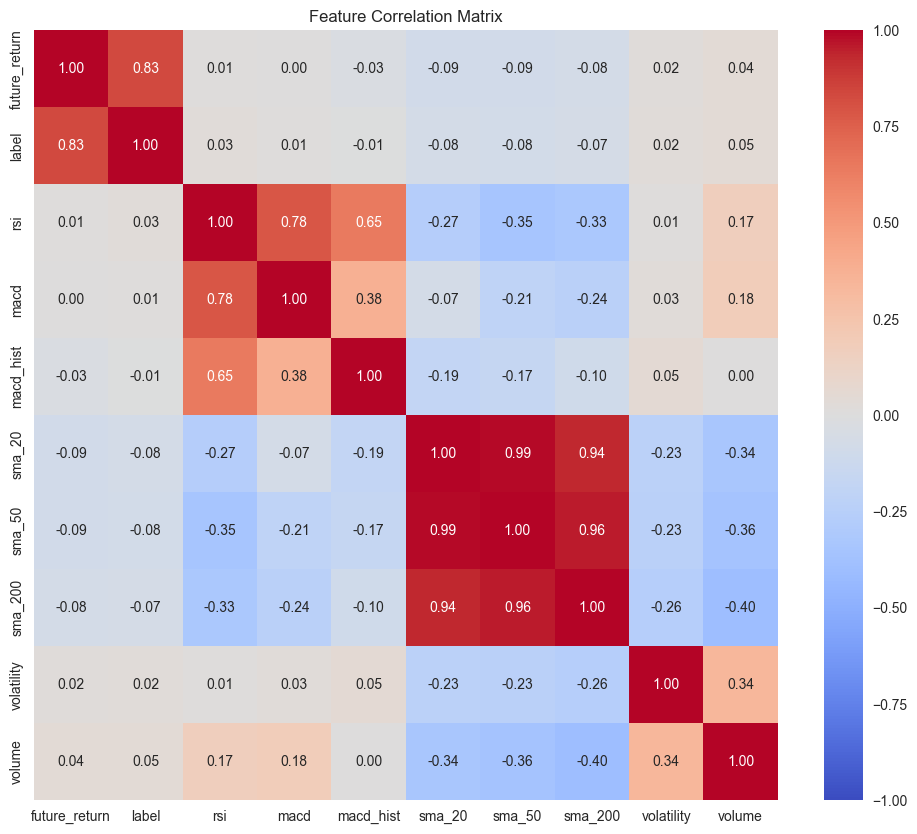

In [7]:
# Select only numeric columns for correlation
# We exclude 'open_time' because it's a date
numeric_cols = [
    'future_return', 'label', 'rsi', 'macd', 'macd_hist', 
    'sma_20', 'sma_50', 'sma_200', 'volatility', 'volume'
]

# Filter columns that actually exist in your dataframe
existing_cols = [col for col in numeric_cols if col in df_final.columns]

plt.figure(figsize=(12, 10))
sns.heatmap(df_final[existing_cols].corr(), annot=True, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1)
plt.title('Feature Correlation Matrix')
plt.show()

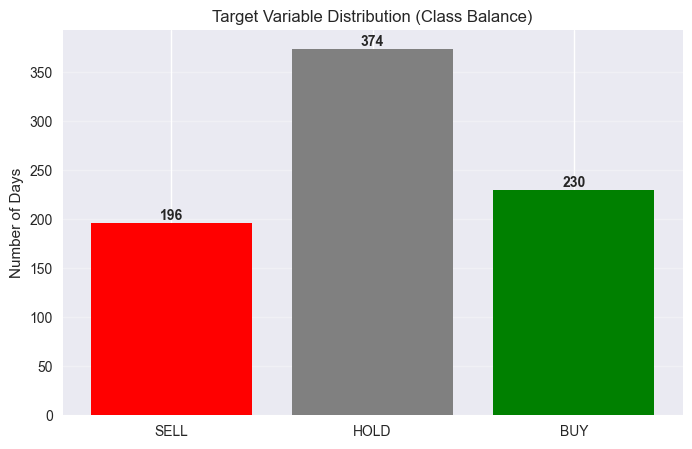

Total Samples: 800


In [8]:
# Map the numeric labels to names for better reading
label_map = {0: 'SELL', 1: 'HOLD', 2: 'BUY'}
label_counts = df_final['label'].value_counts().sort_index()

plt.figure(figsize=(8, 5))
# Colors: Red for Sell, Gray for Hold, Green for Buy
colors = ['red', 'gray', 'green'] 

bars = plt.bar([label_map[i] for i in label_counts.index], label_counts.values, color=colors)

# Add counts on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, height, f'{int(height)}', ha='center', va='bottom', fontweight='bold')

plt.title('Target Variable Distribution (Class Balance)')
plt.ylabel('Number of Days')
plt.grid(axis='y', alpha=0.3)
plt.show()

print(f"Total Samples: {len(df_final)}")